<a href="https://colab.research.google.com/github/kumiori/mec647/blob/Wissam-meshes/mesh_3crackholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys

try:
    import google.colab  # noqa: F401
except ImportError:
    import ufl  # noqa: F401
    import dolfinx  # noqa: F401
else:
    try:
        import ufl
        import dolfinx
    except ImportError:
        !wget "https://fem-on-colab.github.io/releases/fenicsx-install.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh";
        import ufl  # noqa: F401
        import dolfinx  # noqa: F401

In [2]:
%%capture
!sudo apt install libgl1-mesa-glx xvfb;
!{sys.executable} -m pip install pythreejs;
!{sys.executable} -m pip install ipygany;
!{sys.executable} -m pip install --upgrade pyyaml
try:
    import google.colab
except ImportError:
    pass
else:
    pass
    # google.colab.output.enable_custom_widget_manager();
try:
    import pyvista
except ImportError:
    !pip3 install --upgrade pyvista itkwidgets;
    import pyvista  # noqa: F401
    from pyvista.utilities import xvfb

try:
    import gmsh
except ImportError:
    !{sys.executable} -m pip install gmsh
    import gmsh

In [3]:
!rm -rf mec647

try:
  !git clone https://github.com/kumiori/mec647.git
except Exception:
  print('Something went wrong')

  !rm -rf mec647
  !git clone https://github.com/kumiori/mec647.git

Cloning into 'mec647'...
remote: Enumerating objects: 607, done.
remote: Counting objects: 100% (607/607), done.
remote: Compressing objects: 100% (497/497), done.
remote: Total 607 (delta 267), reused 264 (delta 91), pack-reused 0
Receiving objects: 100% (607/607), 12.41 MiB | 16.90 MiB/s, done.
Resolving deltas: 100% (267/267), done.


In [4]:
sys.path.append('mec647/')

In [5]:
from utils.viz import plot_mesh

In [41]:

from mpi4py import MPI


def  mesh_crackholes(name,
                     Lx,
                     Ly,
                     lc,
                     tdim,
                     order=1,
                     msh_file=None,
                     comm=MPI.COMM_WORLD):
    """
    Create mesh of 3d tensile test specimen according to ISO 6892-1:2019 using the Python API of Gmsh.
    """
    # Perform Gmsh work only on rank = 0

    if comm.rank == 0:

        import gmsh

        # Initialise gmsh and set options
        gmsh.initialize()
        gmsh.option.setNumber("General.Terminal", 1)

        gmsh.option.setNumber("Mesh.Algorithm", 6)
        model = gmsh.model()
        model.add("Rectangle")
        model.setCurrent("Rectangle")
        # points = [p1, p2, p3, p4, p5, p6, p7, p8,p9,p10,p11]
        p1 = model.geo.addPoint(0.0, 0.0, 0, lc, tag=1)
        p2 = model.geo.addPoint(1.0, 0.0, 0, lc, tag=2)
        p3 = model.geo.addPoint(1.0, 0.5, 0.0, lc, tag=3)
        p4 = model.geo.addPoint(0, 0.5, 0, lc, tag=4)
        p5 = model.geo.addPoint(0, 0.275, 0.0, lc, tag=5)
        p6 = model.geo.addPoint(0.25, 0.275, 0, lc, tag=6)
        p7 = model.geo.addPoint(0.35, 0.251, 0.0, lc, tag=7)
        p8 = model.geo.addPoint(0.75, 0.25, 0, lc, tag=8)
        p9 = model.geo.addPoint(0.35, 0.249, 0, lc, tag=9)
        p10 = model.geo.addPoint(0.25, 0.225, 0, lc, tag=10)
        p11 = model.geo.addPoint(0, 0.225, 0, lc, tag=11)
        # Lines = [L1, L2, L3, L4, L5, L6, L7, L8]
        bottom = model.geo.addLine(p1, p2, tag=1)
        right= model.geo.addLine(p2, p3, tag=2)
        top = model.geo.addLine(p3, p4, tag=3)
        left1= model.geo.addLine(p4, p5, tag=4)
        halftop= model.geo.addLine(p5, p6, tag=5)
        inclined1= model.geo.addLine(p6, p7, tag=6)
        liptop= model.geo.addLine(p7, p8, tag=7)
        lipbot = model.geo.addLine(p8, p9, tag=8)
        inclined2= model.geo.addLine(p9, p10, tag=9)
        halfbottom= model.geo.addLine(p10, p11, tag=10)
        left2= model.geo.addLine(p11, p1, tag=11)
        cloop1 = model.geo.addCurveLoop([bottom, right, top, left1, halftop,inclined1,liptop,lipbot,inclined2,halfbottom,left2])
        # surface_1 =
        model.geo.addPlaneSurface([cloop1])

        model.geo.synchronize()
        surface_entities = [model[1] for model in model.getEntities(tdim)]
        model.addPhysicalGroup(tdim, surface_entities, tag=1)
        model.setPhysicalName(tdim, 1, "Rectangle surface")

        # Set mesh size via points
        # gmsh.model.mesh.setSize(points, lc)  # heuristic

        # gmsh.model.mesh.optimize("Netgen")

        # Set geometric order of mesh cells
        gmsh.model.mesh.setOrder(order)

        # Define physical groups for subdomains (! target tag > 0)
        # domain = 1
        # gmsh.model.addPhysicalGroup(tdim, [v[1] for v in volumes], domain)
        # gmsh.model.setPhysicalName(tdim, domain, 'domain')
        gmsh.model.addPhysicalGroup(tdim - 1, [5], tag=9)
        gmsh.model.setPhysicalName(tdim - 1, 9, "botfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [6], tag=10)
        gmsh.model.setPhysicalName(tdim - 1, 10, "botfissure2")
        gmsh.model.addPhysicalGroup(tdim - 1, [3], tag=11)
        gmsh.model.setPhysicalName(tdim - 1, 11, "top")
        gmsh.model.addPhysicalGroup(tdim - 1, [1], tag=12)
        gmsh.model.setPhysicalName(tdim - 1, 12, "bottom")
        gmsh.model.addPhysicalGroup(tdim - 1, [7], tag=13)
        gmsh.model.setPhysicalName(tdim - 1, 13, "topfissure1")
        gmsh.model.addPhysicalGroup(tdim - 1, [8], tag=14)
        gmsh.model.setPhysicalName(tdim - 1, 14, "topfissure2")
        

        model.mesh.generate(tdim)


        #Generating the mesh
    model.geo.synchronize()
    model.mesh.generate(tdim)

    return gmsh.model

mesh=mesh_crackholes('mesh', 15, 25, 0.1, 2, 1,)

In [42]:
import meshes
from meshes import primitives

In [43]:
# Parameters

parameters = {
    'loading': {
        'min': 0,
        'max': 1,
        'nteps': 10
    },
    'geometry': {
        'geom_type': 'bar',
        'Lx': 1.,
        'Ly': 0.5
    },
    'model': {
        'E': 1.,
        'nu': 0.,
        'w1': 1.,
        'ell': 0.1,
        'k_res': 1.e-8
    },
    'solvers': {
          'elasticity': {        
            'snes': {
                'snes_type': 'newtontr',
                'snes_stol': 1e-8,
                'snes_atol': 1e-8,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        },
          'damage': {        
            'snes': {
                'snes_type': 'vinewtonrsls',
                'snes_stol': 1e-5,
                'snes_atol': 1e-5,
                'snes_rtol': 1e-8,
                'snes_max_it': 100,
                'snes_monitor': "",
                'ksp_type': 'preonly',
                'pc_type': 'lu',
                'pc_factor_mat_solver_type': 'mumps'
            }
        }
    }
}

In [44]:
import meshes
from meshes import primitives

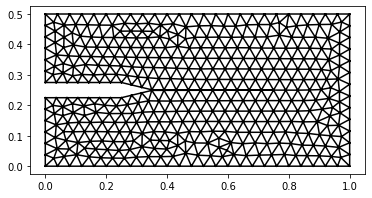

In [52]:
# Mesh

Lx = parameters["geometry"]["Lx"]
Ly = parameters["geometry"]["Ly"]
geom_type = parameters["geometry"]["geom_type"]

gmsh_model=mesh_crackholes('mesh', 15, 25, 0.04, 2, 1)

mesh, mts = meshes.gmsh_model_to_mesh(gmsh_model,
                               cell_data=False,
                               facet_data=True,
                               gdim=2)


from utils.viz import plot_mesh
import matplotlib.pyplot as plt
 
#Plot mesh
plt.figure()
ax = plot_mesh(mesh)
fig = ax.get_figure()
fig.savefig(f"mesh.png")